# Single atom training
This notebook goes through the workflow of setting the hyperparameters, collecting atom manipulation data, and training the deep reinforcement learning agent.

### Importing modules

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from matplotlib import pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
from collections import deque, namedtuple
from matplotlib import pyplot as plt, patches
import torch
from REACTRL import RealExpEnv, Episode_Memory, Createc_Controller, sac_agent, ReplayMemory, HerReplayMemory
from REACTRL import plot_graph, show_reset, show_done, show_step
matplotlib.rcParams['image.cmap'] = 'gray'
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
from matplotlib import pyplot as plt, patches

# Python code to demonstrate namedtuple()
from collections import namedtuple

cpu


### Setting the anchor image
This cell retrieves the current STM scan image and use it as the template for positioning the anchor in STM images

succeed to connect


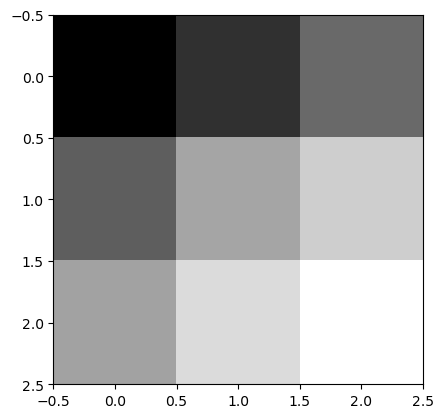

In [2]:
createc_controller = Createc_Controller(None, None, None, None)
img_forward = np.array(createc_controller.stm.scandata(1,4))
#TODO
#Set the pixel of the top-left corner, widht, and height of the anchor
#If the anchor is not used, just set w and h to a small number like below
top_left, w, h = (0,0), 3, 3
#template = img_forward[top_left[1]:top_left[1]+h, top_left[0]:top_left[0]+w]
#plt.imshow(template)

template = img_forward[top_left[1]:top_left[1]+h, top_left[0]:top_left[0]+w]
plt.imshow(template)

### Set the parameters and create a RealExpEnv object

In [3]:
#TODO
step_nm = 0.4 #Set the radius of the manipulation start position relative the the atom start position
goal_nm  = 2 #Set the radius of the manipulation end position relative the the atom start position
max_mvolt = 15 #Set the maximum bias voltage in mV 
max_pcurrent_to_mvolt_ratio = 6E3 #Set the maximum conductance in pA/mV
max_len = 5 #Set maximum episode length
template_max_y = 3 #Set the maximum or minimum row number to search for anchor
#Set the path to load CNN weight for the atom movement classifier
CNN_weight_path = 'C:/LocalUserData/User-data/phys-asp-lab/nian_auto_spm/reaction_rl/training_data_and_model_parameters/model parameters/_atom_move_detector_conv_2460.pth'
current_jump  = 4 #Set the current jump gradient/ std(current) threshold required to take STM scan

#Set STM scan parameters
pixel = 128
im_size_nm = 5 #Image size in nm 
scan_mV = 1000 #bias voltage
x_nm, y_nm = createc_controller.get_offset_nm()
offset_nm = np.array([x_nm, y_nm]) #Set offset to current offset value

#Set manipulation parameters to pull atoms from image edge to center
pull_back_mV = 5 #bias in mV
pull_back_pA = 60000 #current in pA

#Set manipulation limit [left, right, up, down] in nm
manip_limit_nm = np.array([x_nm - 0.5*im_size_nm+0.25, x_nm + 0.5*im_size_nm-0.25, y_nm+0.25, y_nm+im_size_nm-0.25])

env = RealExpEnv(step_nm, max_mvolt, max_pcurrent_to_mvolt_ratio, goal_nm, 
                 template, current_jump, im_size_nm, offset_nm, manip_limit_nm, pixel, 
                 template_max_y, scan_mV, max_len, 
                 CNN_weight_path, 
                 bottom=False, random_scan_rate = 0.8, pull_back_mV = pull_back_mV,
                 pull_back_pA = pull_back_pA)

succeed to connect
Load cnn weight


# Check vertical manipulation

In [ ]:
data=env.createc_controller.dissassmanipulation(60, 60, 12, 50, 800, np.array([79.99261284, 79.99261284]), 5)

In [ ]:
env.createc_controller.ramp_bias_mV(50)
env.createc_controller.set_Z_approach(12)        
env.createc_controller.stm.btn_tipform(40, 40)
env.createc_controller.stm.waitms(50)

In [ ]:
from collections import namedtuple
dissociate_data = namedtuple('dissociate_data',['time','V','Z','current_series','dI_dV','topography'])

time = env.createc_controller.stm.vertdata(0, 0)  # time
V= env.createc_controller.stm.vertdata(1,1)  # voltage
Z = env.createc_controller.stm.vertdata(2,4) # Z
current_series = env.createc_controller.stm.vertdata(3,3) # current series
dI_dV = env.createc_controller.stm.vertdata(4,0) # dI/dV
topography = env.createc_controller.stm.vertdata(15,4)
data = dissociate_data(time,V,Z,current_series, dI_dV, topography)

In [ ]:
plt.scatter(data.time, data.current_series)

# Check lateral manipulation

In [57]:
mvoltage=5
pcurrent=1000
env.createc_controller.ramp_bias_mV(mvoltage)
preamp_grain = 10**float(env.createc_controller.stm.getparam("Latmangain"))
env.createc_controller.stm.setparam("LatmanVolt",  mvoltage) #(mV)
env.createc_controller.stm.setparam("Latmanlgi", pcurrent*1e-9*preamp_grain) #(pA)
env.createc_controller.stm.latmanip(10, 20, 40, 40)

In [34]:
latmandata = namedtuple('latmandata',['time','x','y','current','dI_dV','topography'])
time = env.createc_controller.stm.latmandata(0, 0)
x= env.createc_controller.stm.latmandata(1,4)
y = env.createc_controller.stm.latmandata(2,4)
current = env.createc_controller.stm.latmandata(3,3)
dI_dV = env.createc_controller.stm.latmandata(4,0)
topography = env.createc_controller.stm.latmandata(15,4)
data = latmandata(time,x,y,current, dI_dV,topography)

In [31]:
data=env.createc_controller.lat_manipulation(60, 60, 62, 58, 50, 500, np.array([79.99261284, 79.99261284]), 5)

In [1]:
plt.scatter(data.time, data.V)

# Condition probe

In [ ]:
env.createc_controller.stm.setparam('TipForm_Volt', -3) # Set the bias voltage for the atom manipulation(unit V)

env.createc_controller.stm.setparam('TipForm_Z', 0.0) # Set the z position for the atom manipulation(unit angstrom)

env.createc_controller.stm.setparam('Tip_Delay', 0.4915) # Set the delay time for the atom manipulation(unit s)
env.createc_controller.stm.setparam('Tip_Latddx', 833) # Set the lateral ddx for the atom manipulation(unit angstrom/ms^2)
env.createc_controller.stm.setparam('Tip_LatDelay', 20) # Set the lateral delay for the atom manipulation(unit ms)
env.createc_controller.stm.setparam('Tip_Gain', 6) # Set the gain for the atom manipulation(unit 1)
env.createc_controller.stm.setparam('TipForm_Zoffset', 0.0) # Set the z offset for the atom manipulation(unit angstrom)



In [ ]:
tip_condition_actions={'stall': [0, 0],
                      'soft pulse pos':[0, 2.5],
                      'medium pulse pos': [0, 4.0],
                      'soft pulse neg': [0 , -2.5], 
                      'medium pulse neg': [0, -4],
                      'strong pulse neg': [0, -8],
                      'very soft dip': [0, -8],
                      'soft dip 1': [-0.80, 0.02],
                      'soft dip 2': [-1.2, 0.02],
                      'soft dip 3': [-1.8, 0.02],
                      'medium soft': [-2.5, 0.02],
                      'strong dip': [-5.0, 0.02]
                      }


In [ ]:
env.createc_controller.stm.scanstop()